# Dynamic Programming
Implemented classical dynamic programming algorithms: Policy Iteration (policy evaluation + policy improvement) and Value Iteration. 

In [ ]:
import numpy as np
import copy

import check_test
from frozenlake import FrozenLakeEnv
from plot_utils import plot_values

### Part 0: Environment details - FrozenLake

The agent moves through a $4 \times 4$ grid, with states numbered as follows:
```
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
```
and the agent has 4 potential actions:
```
LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
```

Thus, $\mathcal{S}^+ = \{0, 1, \ldots, 15\}$, and $\mathcal{A} = \{0, 1, 2, 3\}$. The non-deterministic nature of the MDP comes from the (optional) argument `is_slippery` of `FrozenLakeEnv()`, which defaults to `True`.  

In [8]:
env = FrozenLakeEnv()
# print the state space and action space
print(env.observation_space)
print(env.action_space)
# print the total number of states and actions
print(env.nS)
print(env.nA)

Discrete(16)
Discrete(4)
16
4


To access the one-step dynamics of an MDP type `env.P[curr_state][curr_action]`. 

In [9]:
env.P[1][0]

[(0.3333333333333333, 1, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 5, 0.0, True)]

The output is of the form: `(prob, next_state, reward, done)`, where: 
- `prob = Probability(next_state, reward | curr_state, curr_action)`, and
- `done` is `True` if the `next_state` is a terminal state, and otherwise `False`.

Thus, we can interpret `env.P[1][0]` as follows:
$$
\mathbb{P}(S_{t+1}=s',R_{t+1}=r|S_t=1,A_t=0) = \begin{cases}
               \frac{1}{3} \text{ if } s'=1, r=0, \\
               \frac{1}{3} \text{ if } s'=0, r=0, \\
               \frac{1}{3} \text{ if } s'=5, r=0, \\
               0 \text{ else}.
            \end{cases}
$$

### Part 1: Iterative Policy Evaluation

**Input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `policy`: The policy to be evaluated. A 2D np.array s.t.  `policy[s][a] = Probability(action=a | state = s)`, with `policy.shape = (env.nS, env.nA)`. 
- `gamma`: discount rate (`gamma \in [0,1]`).
- `theta`: convergence threshold. 

**Output**:
- `V`: 1D np.array s.t. `V[s]` is the estimated value of state `s` under `policy`, with `V.shape =  (env.nS,)`.

Mathematically, for a given policy $\pi$ the Bellman expectation equation is:
$$
V(s) = \sum_{a \in \mathcal{A}} \pi(a | s) \sum_{s'\in\mathcal{S}, r\in R} \mathbb{P}(s',r | s, a) (r + \gamma V(s'))
$$

In [10]:
def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            Vs = 0
            # For each (action, action probability at s) pair:
            for a, action_prob in enumerate(policy[s]): 
                # For each (probability, next state, reward) tuple given (s,a) 
                for prob, next_state, reward, done in env.P[s][a]:
                    # Update the sum:
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if delta < theta:
            break
    return V

Evaluate the equiprobable random policy $\pi$, where $\pi(a|s) = \frac{1}{|\mathcal{A}(s)|}$ for all $s\in\mathcal{S}$ and $a\in\mathcal{A}(s)$.  

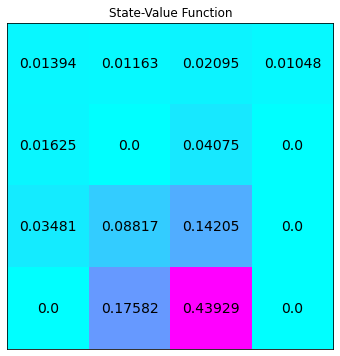

In [12]:
# Specify the policy:
random_policy = np.ones([env.nS, env.nA]) / env.nA
# Evaluate the policy:
V = policy_evaluation(env, random_policy)
# Plot:
plot_values(V)

The function below is provided by Udacity to test correct implementation:

In [13]:
check_test.run_check('policy_evaluation_check', policy_evaluation)

**<span style="color: green;">PASSED</span>**

### Part 2: Obtain $q_\pi$ from $v_\pi$

Input: $v_\pi$ and $s$. Output: $q_\pi(s,a)$ for all $a\in\mathcal{A}(s)$.  

That is the **row in the action-value function** corresponding to the input state $s\in\mathcal{S}$. 

**Input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics. 
- `V`: 1D np.array s.t. `V[s]` is the estimated value of state `s` under `policy`, with `V.shape =  (env.nS,)`. 
- `s`: state (`s \in [0, (env.nS)-1]`). 
- `gamma`: discount rate (`gamma \in [0,1]`). 

**Output**:
- `q`: 1D numpy array s.t. `q[a]` is the (estimated) value of state `s` and action `a`, with `q.shape = (env.nA,)`.

Mathematically, for a given policy $\pi$:
$$
q_{\pi}(a,s) = \sum_{s'\in\mathcal{S}, r\in R} \mathbb{P}(s',r | s, a) (r + \gamma V(s'))
$$

In [15]:
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[s][a]:
            q[a] += prob * (reward + gamma * V[next_state])
    return q

The action-value function corresponding to the previous state-value function:

In [16]:
Q = np.zeros([env.nS, env.nA])
for s in range(env.nS):
    Q[s] = q_from_v(env, V, s)
print("Action-Value Function:")
print(Q)

Action-Value Function:
[[0.0147094  0.01393978 0.01393978 0.01317015]
 [0.00852356 0.01163091 0.0108613  0.01550788]
 [0.02444514 0.02095298 0.02406033 0.01435346]
 [0.01047649 0.01047649 0.00698432 0.01396865]
 [0.02166487 0.01701828 0.01624865 0.01006281]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698432]
 [0.         0.         0.         0.        ]
 [0.01701828 0.04099204 0.03480619 0.04640826]
 [0.07020885 0.11755991 0.10595784 0.05895312]
 [0.18940421 0.17582037 0.16001424 0.04297382]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08799677 0.20503718 0.23442716 0.17582037]
 [0.25238823 0.53837051 0.52711478 0.43929118]
 [0.         0.         0.         0.        ]]


The function below is provided by Udacity to test correct implementation:

In [17]:
check_test.run_check('q_from_v_check', q_from_v)

**<span style="color: green;">PASSED</span>**

### Part 3: Policy Improvement

**Input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `V`: 1D np.array s.t. `V[s]` is the estimated value of state `s` under `policy`, with `V.shape =  (env.nS,)`. 
- `gamma`: discount rate (`gamma \in [0,1]`).

The algorithm returns as **output**:
- `policy`: A 2D np.array s.t.  `policy[s][a] = Probability(action=a | state = s)`, with `policy.shape = (env.nS, env.nA)`. 

Greedily improve a policy (using its estimated value function):
$$
    \pi'(s) \leftarrow \mathrm{argmax}_{a \in \mathcal{A}} \sum_{s'\in\mathcal{S}, r\in R} \mathbb{P}(s',r | s,a) (r + \gamma V_{\pi}(s')) = \mathrm{argmax}_{a \in \mathcal{A}} q_{\pi} (s,a)
$$

In [18]:
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        q = q_from_v(env, V, s, gamma)
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0) / len(best_a)
    return policy

The function below is provided by Udacity to test correct implementation:

In [19]:
check_test.run_check('policy_improvement_check', policy_improvement)

**<span style="color: green;">PASSED</span>**

### Part 4: Policy Iteration

**Input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `gamma`: discount rate (`gamma \in [0,1]`). 
- `theta`: convergence threshold. 

**Output**:
- `policy`: A 2D np.array s.t.  `policy[s][a] = Probability(action=a | state = s)`, with `policy.shape = (env.nS, env.nA)`. 
- `V`: 1D np.array s.t. `V[s]` is the estimated value of state `s` under `policy`, with `V.shape =  (env.nS,)`. 

So essentially we do:
1. Policy evaluation.
2. Policy improvement. 
3. Check convergence.
4. Go back to 1 / Terminate.

In [20]:
def policy_iteration(env, gamma=1, theta=1e-8):
    # Initialize a uniform random policy:
    policy = np.ones([env.nS, env.nA]) / env.nA
    # Perform the policy iteration cycle:
    while True:
        # 1. Policy evaluation --> compute the Value Function estimate:
        V = policy_evaluation(env, policy, gamma, theta)
        # 2. Policy improvement --> compute the improved policy:
        new_policy = policy_improvement(env, V)
        # 3. Check convergence:
        new_V = policy_evaluation(env, new_policy)
        if np.max(abs(new_V - V)) < theta * 1e2:
           break;
        
        policy = copy.copy(new_policy)
    return policy, V

Now solve the MDP and visualize the output. 


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



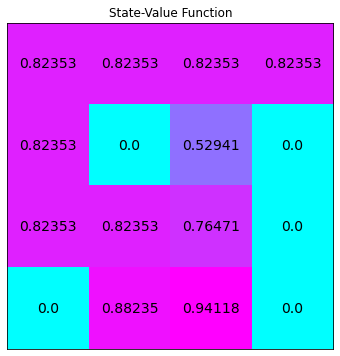

In [22]:
# obtain the optimal policy and optimal state-value function
policy_pi, V_pi = policy_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_pi,"\n")

plot_values(V_pi)

Clear improvement compared to Part 1.

The function below is provided by Udacity to test correct implementation:

In [21]:
check_test.run_check('policy_iteration_check', policy_iteration)

**<span style="color: green;">PASSED</span>**

### Part 5: Truncated Policy Iteration

This is the same as above, but with a `max_it` threshold on the number of iterations when performing Policy Evaluation. 

In [23]:
def truncated_policy_evaluation(env, policy, V, max_it=1, gamma=1):
    num_it=0
    while num_it < max_it:
        for s in range(env.nS):
            Vs = 0
            # For each (action, action probability at s) pair:
            for a, action_prob in enumerate(policy[s]): 
                # For each (probability, next state, reward) tuple given (s,a) 
                for prob, next_state, reward, done in env.P[s][a]:
                    # Update the sum:
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
            V[s] = Vs
        num_it += 1
    return V

In [24]:
def truncated_policy_iteration(env, max_it=1, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:
        policy = policy_improvement(env, V)
        old_V = copy.copy(V)
        V = truncated_policy_evaluation(env, policy, V, max_it, gamma)
        if max(abs(V-old_V)) < theta:
            break;
    return policy, V

Now solve the MDP and visualize the output. Changing `max_it` has an effect on the computed state-value of course. 


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



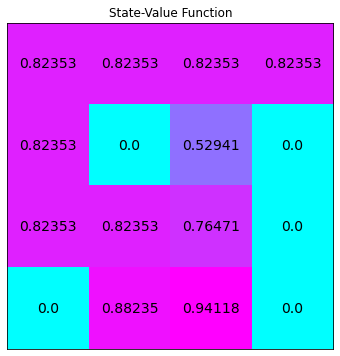

In [25]:
policy_tpi, V_tpi = truncated_policy_iteration(env, max_it=2)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_tpi,"\n")

# plot the optimal state-value function
plot_values(V_tpi)

The function below is provided by Udacity to test correct implementation:

In [26]:
check_test.run_check('truncated_policy_iteration_check', truncated_policy_iteration)

**<span style="color: green;">PASSED</span>**

### Part 6: Value Iteration

**Input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `gamma`: discount rate (`gamma \in [0,1]`). 
- `theta`: convergence threshold. 

**Output**:
- `policy`: A 2D np.array s.t.  `policy[s][a] = Probability(action=a | state = s)`, with `policy.shape = (env.nS, env.nA)`. 
- `V`: 1D np.array s.t. `V[s]` is the estimated value of state `s` under `policy`, with `V.shape =  (env.nS,)`. 

Value iteration is a method of computing an optimal MDP policy and its value:
$$
Q_{k+1}(s,a) = \sum_{s'\in\mathcal{S}} \mathbb{P}(s'| s,a) (r + \gamma V_{k}(s'))
$$
$$
V_{k}(s) = \mathrm{max}_{a \in \mathcal{A}} Q_{k}(s,a)
$$


In [28]:
def value_iteration(env, gamma=1, theta=1e-8):
    # Initialize V:
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state s, V[s] = max( q_from_v(s) )
        for s in range(env.nS):
            v = V[s]
            V[s] = max(q_from_v(env, V, s, gamma))
            delta = max(delta,abs(V[s]-v))
        if delta < theta:
            break
    policy = policy_improvement(env, V, gamma)
    return policy, V

Now solve the MDP and visualize the output.


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



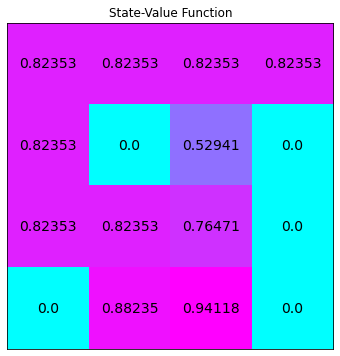

In [29]:
policy_vi, V_vi = value_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_vi,"\n")

# plot the optimal state-value function
plot_values(V_vi)

The function below is provided by Udacity to test correct implementation:

In [30]:
check_test.run_check('value_iteration_check', value_iteration)

**<span style="color: green;">PASSED</span>**